In [1]:
%ls data

archive.zip                            olist_orders_dataset.csv
olist_customers_dataset.csv            olist_products_dataset.csv
olist_geolocation_dataset.csv          olist_products_dataset_po.csv
olist_order_items_dataset.csv          olist_sellers_dataset.csv
olist_order_payments_dataset.csv       product_category_name_translation.csv
olist_order_reviews_dataset.csv


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

In [3]:
geo_data = pd.read_csv('data/olist_geolocation_dataset.csv')
order_data = pd.read_csv('data/olist_orders_dataset.csv')
order_item_data = pd.read_csv('data/olist_order_items_dataset.csv')
products_data = pd.read_csv('data/olist_products_dataset.csv')
sellers_data = pd.read_csv('data/olist_sellers_dataset.csv')
payment_data = pd.read_csv('data/olist_order_payments_dataset.csv')

In [5]:
order_data.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

**결측값의 비율은 약 3%이므로 'order_delivered_customer_date'의 Null 값은 'order_estimated_delivery_date'로 채우기**

In [6]:
## **결측값의 비율은 약 3%이므로 고객 날짜 기능의 Null 값은 forward-fill method로 채우기**
# order_data['order_delivered_customer_date']= order_data['order_delivered_customer_date'].fillna(method='ffill')
# order_data['order_delivered_customer_date'].isnull().sum()

In [8]:
order_data['order_delivered_customer_date']= order_data['order_delivered_customer_date'].fillna(order_data['order_estimated_delivery_date'])
order_data['order_delivered_customer_date'].isnull().sum()

0

**배송 완료 날짜 및 예상 날짜 컬럼 생성**

In [9]:
order_data['delivered_time']=pd.to_datetime(order_data['order_delivered_customer_date'],
                                            format='%Y-%m-%d').dt.date
order_data['estimate_time']=pd.to_datetime(order_data['order_estimated_delivery_date'], 
                                           format='%Y-%m-%d').dt.date

**주문 배송된 고객 날짜를 기준으로 Weekly 생성**

In [10]:
order_data['weekly']=pd.to_datetime(order_data['order_delivered_customer_date'],
                                    format='%Y-%m-%d').dt.week

<ipython-input-10-7141a3e5f4d0>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  order_data['weekly']=pd.to_datetime(order_data['order_delivered_customer_date'],


**주문 배송된 고객 날짜를 기반으로 Monthly 생성**

In [11]:
order_data['monthly']=pd.to_datetime(order_data['order_delivered_customer_date'])\
                    .dt.to_period('M')
order_data['monthly']= order_data['monthly'].astype(str)

**예상 날짜와 배송된 날짜의 차이로 diff_days 생성**

In [12]:
order_data['diff_days']= order_data['delivered_time']-order_data['estimate_time']
order_data['diff_days']= order_data['diff_days'].dt.days

In [13]:
# 배송완료된 주문제품만
order_data_delivery = order_data[order_data["order_status"]=='delivered']

In [14]:
# 배송완료 예정 날짜보다 늦게 배송된 경우
order_data_delivery[order_data_delivery['diff_days']>0].shape

(6534, 13)

In [15]:
# 배송완료 예정 날짜 = 실제 배송완료 날짜
order_data_delivery[order_data_delivery['diff_days']==0].shape

(1300, 13)

In [16]:
# 배송완료 예정 날짜보다 빨리 배송된 경우
order_data_delivery[order_data_delivery['diff_days']<0].shape

(88644, 13)

In [17]:
order_data_delivery.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivered_time,estimate_time,weekly,monthly,diff_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10-10,2017-10-18,41,2017-10,-8
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018-08-07,2018-08-13,32,2018-08,-6


In [18]:
order_data_delivery.groupby(['weekly'])["diff_days"].mean()

weekly
1     -9.179291
2    -11.274967
3    -13.562369
4    -14.163656
5    -15.182986
6    -16.203322
7    -15.799630
8    -13.617605
9    -11.401540
10   -10.357715
11    -9.141724
12    -8.606580
13    -9.058068
14    -7.699257
15    -8.748567
16    -9.904279
17   -11.989136
18   -11.790677
19   -11.844112
20   -11.816672
21   -11.213804
22   -11.815772
23   -13.277978
24   -18.280579
25   -16.657393
26   -16.180823
27   -15.812530
28   -14.131258
29   -12.202691
30   -11.657437
31   -11.331565
32    -9.960604
33    -8.816615
34   -10.163465
35   -10.815978
36   -11.667949
37   -10.772212
38    -5.782814
39   -11.297828
40   -13.302050
41   -15.554979
42   -13.951473
43   -13.352159
44   -12.252772
45   -11.619243
46   -10.698646
47   -10.564319
48   -10.555990
49   -11.439655
50   -11.378305
51   -10.894824
52   -11.250749
Name: diff_days, dtype: float64

Text(0.5, 1.0, 'Average Difference Days per Week')

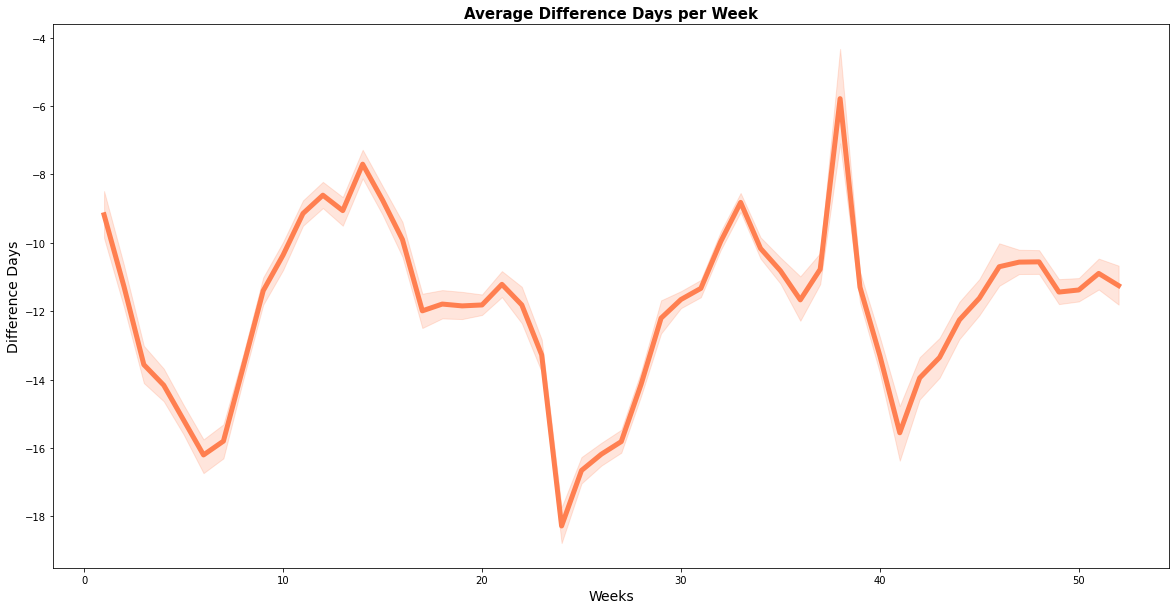

In [19]:
plt.figure(figsize=(20,10))
sns.lineplot(x='weekly', y='diff_days', data=order_data_delivery, color="coral", linewidth=5,
            markers=True,dashes=False, estimator='mean')

plt.xlabel("Weeks", size=14)
plt.ylabel("Difference Days", size=14)
plt.title("Average Difference Days per Week",size=15, weight='bold')

In [20]:
order_data_delivery.groupby(['monthly'])["diff_days"].mean()

monthly
2016-10   -41.434146
2016-11   -20.379310
2016-12    -7.250000
2017-01   -30.056537
2017-02   -25.159141
2017-03   -14.372796
2017-04   -14.546241
2017-05   -12.490269
2017-06   -13.530397
2017-07   -12.523300
2017-08   -13.255463
2017-09   -10.343001
2017-10   -12.648865
2017-11   -10.765310
2017-12   -11.242992
2018-01   -11.997878
2018-02   -12.132479
2018-03    -7.889215
2018-04    -8.353758
2018-05   -11.275489
2018-06   -16.790630
2018-07   -13.676762
2018-08    -8.372865
2018-09    22.553571
2018-10    83.666667
Name: diff_days, dtype: float64

Text(0.5, 1.0, 'Average Difference Days per Month')

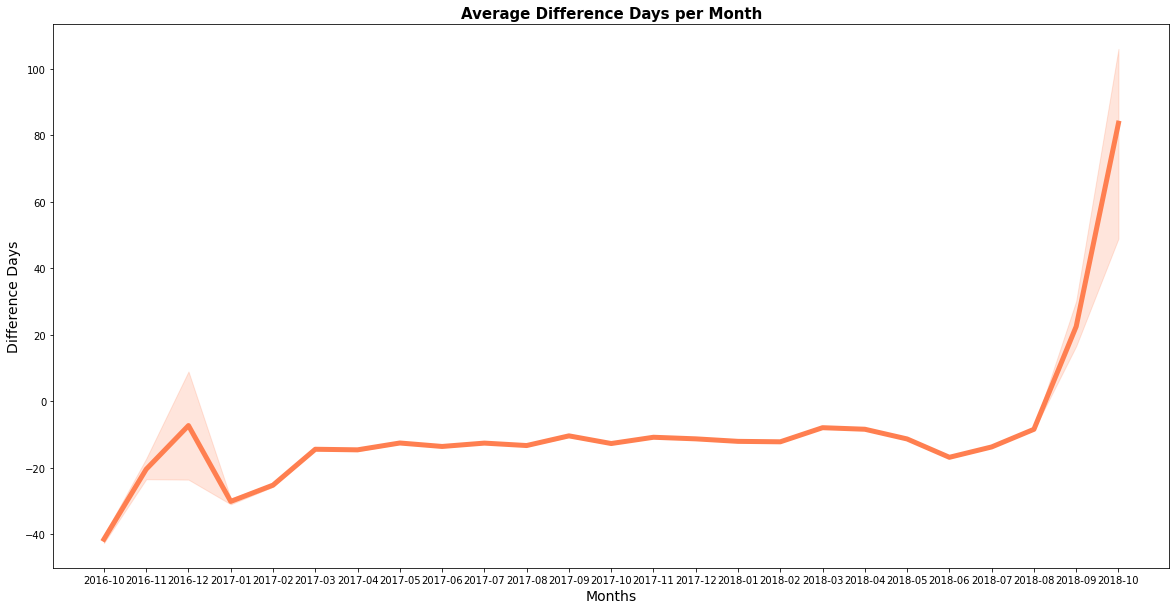

In [21]:
order_data_delivery1 = order_data_delivery
order_data_delivery1 = order_data_delivery.sort_values('monthly')

plt.figure(figsize=(20,10))
sns.lineplot(x='monthly', y='diff_days', data=order_data_delivery1, color="coral", linewidth=5,
            markers=True,dashes=False,estimator='mean')

plt.xlabel("Months", size=14)
plt.ylabel("Difference Days", size=14)
plt.title("Average Difference Days per Month",size=15, weight='bold')

**배송예상날짜와 배송완료날짜 차이를 판매자와 카테고리별로 보기 위해**

In [22]:
df_orders = pd.merge(order_data, order_item_data, on="order_id",how = 'right')

In [23]:
df_orders = pd.merge(df_orders, products_data, on="product_id",how = 'right')

In [24]:
df_orders = df_orders.drop_duplicates(['order_id','product_id'], keep = 'first')

In [25]:
df_orders[df_orders.duplicated(['order_id','product_id'])]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivered_time,estimate_time,...,freight_value,product_category_name,product_category_name_port,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm


In [26]:
# 배송완료된 주문 제품만
df_orders_delivery = df_orders[df_orders["order_status"]=='delivered']

**seller별 배송예상날짜와 실제배송날짜 차이 평균**

In [103]:
df_orders_delivery.groupby(['seller_id'])["diff_days"].mean().sort_values()

seller_id
933446e9a59dece7ae9175103820ca8f    -66.0
0b09101900100c0e9d312861fad5a1b9    -61.0
fa5fdc4e4bb6bd1009ad0e4ac4096562    -58.0
ffff564a4f9085cd26170f4732393726    -48.0
58e4b302b54937e55a678c4d15111da4    -48.0
                                    ...  
8629a7efec1aab257e58cda559f03ba7     33.0
4fb41dff7c50136976d1a5cf004a42e2     33.0
8e670472e453ba34a379331513d6aab1     35.0
f9bbdd976532d50b7816d285a22bd01e    136.0
df683dfda87bf71ac3fc63063fba369d    167.0
Name: diff_days, Length: 2970, dtype: float64

**카테고리별 배송예상날짜와 실제배송날짜 차이 평균**

In [28]:
df_orders.groupby(['product_category_name'])["diff_days"].mean().sort_values()

product_category_name
security_and_services               -17.000000
la_cuisine                          -16.384615
cds_dvds_musicals                   -15.833333
fixed_telephony                     -14.562212
fashion_shoes                       -14.521236
                                       ...    
home_confort                         -9.679803
food                                 -9.626932
home_comfort_2                       -8.708333
furniture_mattress_and_upholstery    -6.973684
arts_and_craftmanship                -6.791667
Name: diff_days, Length: 71, dtype: float64

In [66]:
df_orders_delivery['diff_days'].sort_values()

84882    -147
103127   -140
20985    -135
87161    -124
59215    -109
         ... 
36542     166
95255     167
110636    175
1466      181
86906     188
Name: diff_days, Length: 100196, dtype: int64

Text(0.5, 1.0, 'Average Difference Days per Category')

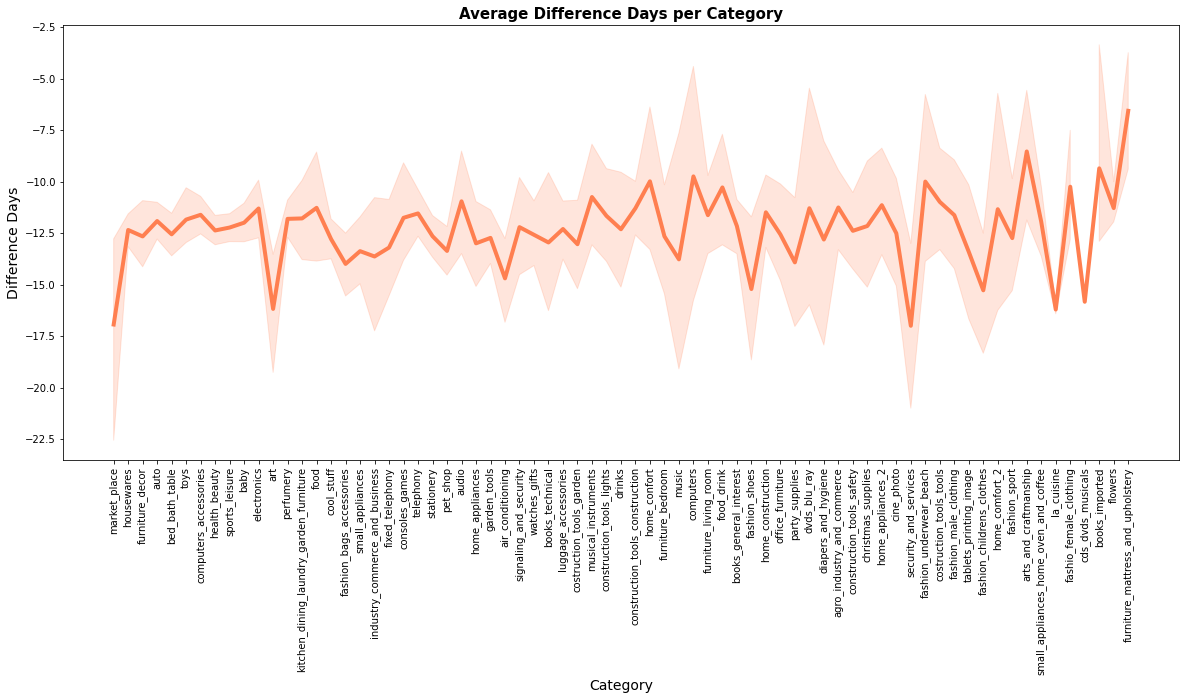

In [85]:
df_agg1 = df_agg
df_agg1 = df_agg.sort_values('diff_days')

plt.figure(figsize=(20,8))
sns.lineplot(x='product_category_name', y='diff_days', data=df_agg1, color="coral", linewidth=4,
            markers=True,dashes=False,estimator='mean')
plt.xticks(rotation=90)
plt.xlabel("Category", size=14)
plt.ylabel("Difference Days", size=14)
plt.title("Average Difference Days per Category",size=15, weight='bold')

**카테고리별 셀러의 배송예상날짜와 실제배송날짜 차이 평균 순위**

In [53]:
# 첫 번째 그룹바이
df_agg = df_orders_delivery.groupby(['product_category_name','seller_id']).agg({'diff_days':'mean'})
df_agg

diff_days
product_category_name      seller_id                                  
agro_industry_and_commerce 06579cb253ecd5a3a12a9e6eb6bf8f47 -10.000000
                           0ed6ce5d87fd9c69eaacaeb778d67235  -9.000000
                           2528744c5ef5d955adc318720a94d2e7  -9.400000
                           269cff2d3c8d205c11f37a52402ea93b  -9.000000
                           31ae0774c17fabd06ff707cc5bde005f -12.857143
...                                                                ...
watches_gifts              f8db351d8c4c4c22c6835c19a46f01b0 -11.200000
                           f9eedec3129e8cc6b6429c42d0808c5b  -9.000000
                           fa1c13f2614d7b5c4749cbc52fecda94 -10.309441
                           fcba71d4d5db057f43249145e4eb1e27  -7.666667
                           ffc470761de7d0232558ba5e786e57b7 -13.400000

[6144 rows x 1 columns]

In [54]:
# 인덱스의 첫 번째 수준으로 그룹화
g = df_agg['diff_days'].groupby(level=0, group_keys=False)

In [62]:
# 각 그룹 내에서 diff_days 열을 내림차순으로 정렬하고 상위 3 개 행만 가져오기
#delivery_ = g.apply(lambda x: x.order(ascending=False).head(3))
delivery_fast = g.apply(lambda x: x.sort_values(ascending=False).tail(3))
delivery_fast

product_category_name       seller_id                       
agro_industry_and_commerce  6b2612338467c08c9b25f0cc55b1578d   -22.000000
                            85cc55e048b6bcc90c75afe7f0e72f72   -23.000000
                            55bb6fe5bebe5012e2d7d9928e1128ff   -24.000000
air_conditioning            ac6417315ae5da8f9a38ee11de6f7780   -28.000000
                            c7dcd301ecfe5ab7f778ac172cf74be7   -29.000000
                                                                  ...    
toys                        e883aa812c37a7413226856f4579fe91   -37.000000
                            4bde6149c15cf7e177b36fa060dd6de8   -52.000000
watches_gifts               710e3548e02bc1d2831dfc4f1b5b14d4   -29.666667
                            747e73c01a4593d4cf60dcf970fd2689   -30.000000
                            9f505651f4a6abe901a56cdc21508025   -33.333333
Name: diff_days, Length: 209, dtype: float64

In [59]:
delivery_slow = g.apply(lambda x: x.sort_values(ascending=False).head(3))
delivery_slow

product_category_name       seller_id                       
agro_industry_and_commerce  3d0cd21d41671c46f82cd11176bf7277    -2.000000
                            397c4d0c005b6f41f90098ac724e28cb    -3.000000
                            6bd69102ab48df500790a8cecfc285c2    -3.600000
air_conditioning            15aac934c58d886785ac1b17953ea898     4.666667
                            b2ba3715d723d245138f291a6fe42594    -2.000000
                                                                  ...    
toys                        4c8b8048e33af2bf94f2eb547746a916    12.000000
                            bdb3edbaee43a761e2d4f258dc08f348     7.000000
watches_gifts               4fb41dff7c50136976d1a5cf004a42e2    33.000000
                            e7df4cd29ab5abab70fb0783ddb53987     6.000000
                            e82de6494d91d3c4c54450f59b227a94     3.000000
Name: diff_days, Length: 209, dtype: float64

In [68]:
# 한번에 보기
df_orders_delivery.groupby(['product_category_name']).apply(lambda x: (x.groupby('seller_id')
                                      .mean()
                                      .sort_values('diff_days', ascending=False))
                                     .tail(3))

weekly  \
product_category_name      seller_id                                     
agro_industry_and_commerce 6b2612338467c08c9b25f0cc55b1578d   9.000000   
                           85cc55e048b6bcc90c75afe7f0e72f72  31.000000   
                           55bb6fe5bebe5012e2d7d9928e1128ff  22.500000   
air_conditioning           ac6417315ae5da8f9a38ee11de6f7780  19.000000   
                           c7dcd301ecfe5ab7f778ac172cf74be7  43.000000   
...                                                                ...   
toys                       e883aa812c37a7413226856f4579fe91  34.000000   
                           4bde6149c15cf7e177b36fa060dd6de8  41.000000   
watches_gifts              710e3548e02bc1d2831dfc4f1b5b14d4  34.000000   
                           747e73c01a4593d4cf60dcf970fd2689  14.333333   
                           9f505651f4a6abe901a56cdc21508025  21.666667   

                                                             diff_days  \
product_category_name      seller_id                                     
agro_industry_and_commerce 6b2612338467c08c9b25f0cc55b1578d -22.000000   
                           85cc55e048b6bcc90c75afe7f0e72f72 -23.000000   
                           55bb6fe5bebe5012e2d7d9928e1128ff -24.000000   
air_conditioning           ac6417315ae5da8f9a38ee11de6f7780 -28.000000   
                           c7dcd301ecfe5ab7f778ac172cf74be7 -29.000000   
...                                                                ...   
toys                       e883aa812c37a7413226856f4579fe91 -37.000000   
                           4bde6149c15cf7e177b36fa060dd6de8 -52.000000   
watches_gifts              710e3548e02bc1d2831dfc4f1b5b14d4 -29.666667   
                           747e73c01a4593d4cf60dcf970fd2689 -30.000000   
                           9f505651f4a6abe901a56cdc21508025 -33.333333   

                                                             order_item_id  \
product_category_name      seller_id                                         
agro_industry_and_commerce 6b2612338467c08c9b25f0cc55b1578d            1.0   
                           85cc55e048b6bcc90c75afe7f0e72f72            1.0   
                           55bb6fe5bebe5012e2d7d9928e1128ff            1.0   
air_conditioning           ac6417315ae5da8f9a38ee11de6f7780            1.0   
                           c7dcd301ecfe5ab7f778ac172cf74be7            1.0   
...                                                                    ...   
toys                       e883aa812c37a7413226856f4579fe91            1.0   
                           4bde6149c15cf7e177b36fa060dd6de8            1.0   
watches_gifts              710e3548e02bc1d2831dfc4f1b5b14d4            1.0   
                           747e73c01a4593d4cf60dcf970fd2689            1.0   
                           9f505651f4a6abe901a56cdc21508025            1.0   

                                                                  price  \
product_category_name      seller_id                                      
agro_industry_and_commerce 6b2612338467c08c9b25f0cc55b1578d   92.900000   
                           85cc55e048b6bcc90c75afe7f0e72f72   33.900000   
                           55bb6fe5bebe5012e2d7d9928e1128ff   98.500000   
air_conditioning           ac6417315ae5da8f9a38ee11de6f7780  110.300000   
                           c7dcd301ecfe5ab7f778ac172cf74be7  299.990000   
...                                                                 ...   
toys                       e883aa812c37a7413226856f4579fe91   59.900000   
                           4bde6149c15cf7e177b36fa060dd6de8   79.900000   
watches_gifts              710e3548e02bc1d2831dfc4f1b5b14d4  149.990000   
                           747e73c01a4593d4cf60dcf970fd2689  739.330000   
                           9f505651f4a6abe901a56cdc21508025   21.656667   

                                                             freight_value  \
product_category_name      seller_id                                 

In [67]:
df_orders_delivery['product_category_name'].unique().tolist()

['perfumery',
 'art',
 'sports_leisure',
 'baby',
 'housewares',
 'musical_instruments',
 'cool_stuff',
 'furniture_decor',
 'home_appliances',
 'toys',
 'bed_bath_table',
 'construction_tools_safety',
 'computers_accessories',
 'health_beauty',
 'luggage_accessories',
 'garden_tools',
 'office_furniture',
 'auto',
 'electronics',
 'fashion_shoes',
 'telephony',
 'stationery',
 'fashion_bags_accessories',
 'computers',
 'home_construction',
 'watches_gifts',
 'construction_tools_construction',
 'pet_shop',
 'small_appliances',
 'agro_industry_and_commerce',
 nan,
 'furniture_living_room',
 'signaling_and_security',
 'air_conditioning',
 'consoles_games',
 'books_general_interest',
 'costruction_tools_tools',
 'fashion_underwear_beach',
 'fashion_male_clothing',
 'kitchen_dining_laundry_garden_furniture',
 'industry_commerce_and_business',
 'fixed_telephony',
 'construction_tools_lights',
 'books_technical',
 'home_appliances_2',
 'party_supplies',
 'drinks',
 'market_place',
 'la_cuisi